In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from config.config import LSTM_DATA_DIR, OBSERVACIONS_FILTRAT_DIR, LSTM_PREDICTIONS_DIR, OBSERVACIONS_DIR, AUTOENCODER_DIR
import pandas as pd
import os
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras import regularizers
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import joblib
from src.LSTM import flatten, scale_data_anomaly_detection
from src.utils import parse_station

In [35]:
#get all the files in the directory
files = os.listdir(LSTM_PREDICTIONS_DIR)

In [36]:
data_all_stations = []
data_all_stations_test = []
normalization_features = []
input_length = 14

#read all the files that are csv
for file in files:
    if file.endswith(".csv"):

        lstm_fitted = parse_station(file.replace('.csv', '_stats.csv'), only_testing = True)
        nash = lstm_fitted.nash()

    
        if nash > 0.2:
            print('aaa', nash)
            df = pd.read_csv(os.path.join(LSTM_PREDICTIONS_DIR / file))

            df['ds'] = pd.to_datetime(df['ds'])

            #marquem com a anomalia els valors que son nans al fitxer observacions_filtrat pero no al fitxer observacions original
            df_observacions_originals = pd.read_csv(os.path.join(OBSERVACIONS_DIR / file), parse_dates = ['Date'])
            df_observacions_filtrades = pd.read_csv(os.path.join(OBSERVACIONS_FILTRAT_DIR / file), parse_dates = ['Date'])

            df_observacions_originals.rename(columns = {'Date': 'ds', 'Flow': 'y_original'}, inplace = True)
            df_observacions_filtrades.rename(columns = {'Date': 'ds', 'Flow': 'y_original_filtrades'}, inplace = True)

            df = df.merge(df_observacions_originals, on = 'ds', how = 'left')
            df = df.merge(df_observacions_filtrades, on = 'ds', how = 'left')


            #add column is anomaly, if y_original is not na and y_original_filtrades is na, then is anomaly
            #df['is_anomaly'] = df['y_original'].notna() & df['y_original_filtrades'].isna()
            df['is_anomaly'] = df['y_original_filtrades'].isna()    #train autoencoder without anomaly or empty data

            #Afegim els 150 de la finestra de look-back (traiem l'últim 15% tenint en compte la serie sencera)
            n = len(df) + 150 

            df_train = df[:int(n*0.85)]
            df_test = df[int(n*0.85):]


            #duplicate last row with concat
            df_train = pd.concat([df_train, df_train.iloc[[-1]]])
            df_test = pd.concat([df_test, df_test.iloc[[-1]]])

            #move is_anomaly values to next row. That way, generator will return [(sliding window of 14 values, is_anomaly of 14th value))]
            df_train['is_anomaly'] = df_train['is_anomaly'].shift(+1)
            df_test['is_anomaly'] = df_test['is_anomaly'].shift(+1)

            generator = TimeseriesGenerator(df_train[['y', 'yhat']].values, df_train['is_anomaly'].values, length=14, batch_size=1)
            test_generator = TimeseriesGenerator(df_test[['y', 'yhat']].values, df_test['is_anomaly'].values, length=14, batch_size=1)


            merged_generator = np.array([sample[0][0] for sample in generator if not sample[1][0]])
            merged_generator_test = np.array([sample[0][0] for sample in test_generator if not sample[1][0]])

            data_all_stations.extend(merged_generator)
            data_all_stations_test.extend(merged_generator_test)

            print(nash)

30/30 [==============================] - 1s 11ms/step
aaa 0.2226713530528429
0.2226713530528429
30/30 [==============================] - 1s 13ms/step
aaa 0.21289693739516902
0.21289693739516902
30/30 [==============================] - 1s 12ms/step
aaa 0.32709936712823073
0.32709936712823073
30/30 [==============================] - 1s 11ms/step
aaa 0.31185743627751294
0.31185743627751294
30/30 [==============================] - 0s 10ms/step
aaa 0.2729130042816642
0.2729130042816642
30/30 [==============================] - 1s 13ms/step
aaa 0.2625266647307024
0.2625266647307024
30/30 [==============================] - 0s 7ms/step
aaa 0.21674448885347253
0.21674448885347253
30/30 [==============================] - 0s 8ms/step
aaa 0.2977301556588704
0.2977301556588704
30/30 [==============================] - 0s 10ms/step
aaa 0.39996853081903627
0.39996853081903627
30/30 [==============================] - 0s 7ms/step
aaa 0.45428526017513327
0.45428526017513327
30/30 [========================

In [37]:
X_train = scale_data_anomaly_detection(data_all_stations)
X_test = scale_data_anomaly_detection(data_all_stations_test)

In [38]:
def autoencoder_model(X):
    inputs = Input(shape = (X.shape[1], X.shape[2]))
    L1 = LSTM(32, return_sequences=True)(inputs)
    L2 = LSTM(16, return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, return_sequences=True)(L3)
    L5 = LSTM(32, return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [39]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 2)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 14, 32)            4480      
                                                                 
 lstm_9 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 14, 16)           0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 14, 16)            2112      
                                                                 
 lstm_11 (LSTM)              (None, 14, 32)            6272      
                                                           

In [40]:
nb_epochs = 50
batch_size = 64
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.2).history

Epoch 1/50
799/799 [==============================] - 11s 11ms/step - loss: 0.1207 - val_loss: 0.0977
Epoch 2/50
799/799 [==============================] - 8s 10ms/step - loss: 0.0934 - val_loss: 0.0917
Epoch 3/50
799/799 [==============================] - 8s 10ms/step - loss: 0.0856 - val_loss: 0.0844
Epoch 4/50
799/799 [==============================] - 8s 10ms/step - loss: 0.0804 - val_loss: 0.0809
Epoch 5/50
799/799 [==============================] - 8s 10ms/step - loss: 0.0776 - val_loss: 0.0778
Epoch 6/50
799/799 [==============================] - 8s 10ms/step - loss: 0.0747 - val_loss: 0.0747
Epoch 7/50
799/799 [==============================] - 8s 10ms/step - loss: 0.0714 - val_loss: 0.0735
Epoch 8/50
799/799 [==============================] - 8s 10ms/step - loss: 0.0697 - val_loss: 0.0715
Epoch 9/50
799/799 [==============================] - 8s 10ms/step - loss: 0.0684 - val_loss: 0.0696
Epoch 10/50
799/799 [==============================] - 8s 10ms/step - loss: 0.0676 - val_l

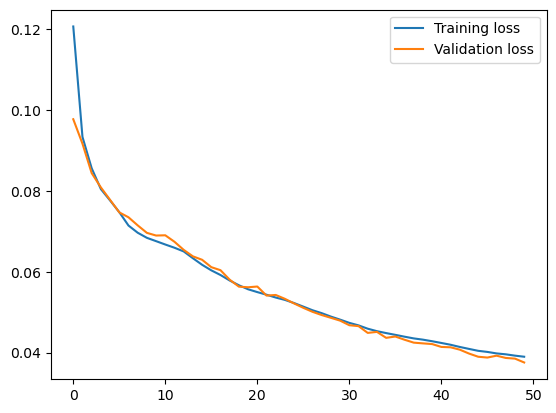

In [41]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()


Reconstruction error threshold: 0.33636200112593584


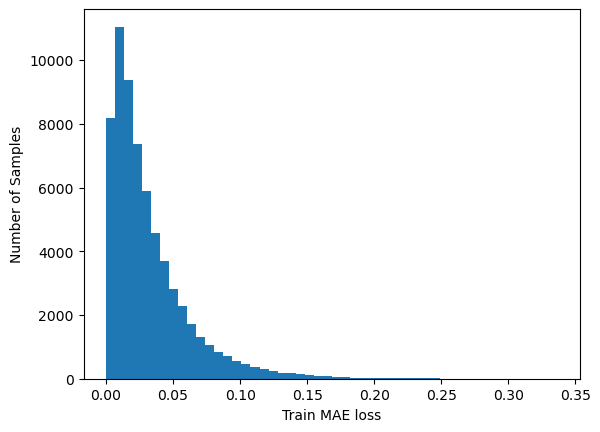

In [42]:
#Find MAE loss on training samples
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(flatten(X_train_pred) - flatten(X_train)), axis=1)


plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')


In [43]:
#90 percentile
threshold = np.percentile(train_mae_loss, 95)
print(f'Reconstruction error threshold on 90 percentile: {threshold}')

Reconstruction error threshold on 90 percentile: 0.09277027962005668


In [44]:
#store model
model.save(AUTOENCODER_DIR / 'lstm_autoencoder.h5')

#store scaler
#joblib.dump(scaler, AUTOENCODER_DIR / 'scaler.pkl')